# Indicium - Desafio Cientista de Dados | Programa Lighthouse

O objetivo deste projeto é desenvolver um modelo de regressão e uma análise exploratória detalhada para identificar os fatores-chave que determinam o sucesso de um filme.

In [247]:
# importa as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from catboost.core import CatBoostRegressor


import pickle

import warnings
warnings.filterwarnings('ignore')

# Importação da base de dados

In [248]:
df_movies = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)

print(df_movies.shape)
df_movies.head()

(999, 15)


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


### Dicionário dos Dados

O DataFrame apresentou **999 registros** e **15 variáveis**, com as seguintes variáveis:

*   **Series_Title** – Nome do filme
*   **Released_Year** - Ano de lançamento
*   **Certificate** - Classificação etária
*   **Runtime** – Tempo de duração
*   **Genre** - Gênero
*   **IMDB_Rating** - Nota do IMDB
*   **Overview** - Overview do filme
*   **Meta_score** - Média ponderada de todas as críticas
*   **Director** – Diretor
*   **Star1** - Ator/atriz #1
*   **Star2** - Ator/atriz #2
*   **Star3** - Ator/atriz #3
*   **Star4** - Ator/atriz #4
*   **No_of_Votes** - Número de votos
*   **Gross** - Faturamento

---


# Análise Exploratória (EDA)

A próxima etapa foi realizar uma Análise Exploratória para entender a estrutura, a qualidade e as características dos dados.

Para a análise inicial da estrutura do dataset, foi executado o método .info()

In [249]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


Foi verificado que as colunas numéricas, released_Year, runtime e gross, estavam formatadas com o tipo de dado object.

Havia a presença de valores nulos nas colunas Gross, Meta_score e Certificate

---

Para obter um resumo estatístico das variáveis numéricas, foi utilizado o método .describe().

In [250]:
df_movies.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,842.000000,9.990000e+02
mean,7.947948,77.969121,2.716214e+05
std,0.272290,12.383257,3.209126e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.547150e+04
50%,7.900000,79.000000,1.383560e+05
75%,8.100000,87.000000,3.731675e+05
max,9.200000,100.000000,2.303232e+06


Foi observado que:

*   **Distribuição das notas (IMDB_Rating)**
    -   Média: 7.95, Mínimo: 7.6, Máximo: 9.2
    -  Desvio padrão: 0.27

*   **Distribuição das avaliações da crítica (Meta_score)**
    *   Média: 77.97, desvio de 12.38.
    *   Intervalo grande: 28 (min) a 100 (max)
    *   25% dos filmes têm Meta_score abaixo de 70

*   **Votos recebidos (No_of_Votes)**
    *   Média: 271 mil, mas com um desvio padrão grande (~320 mil).
    *   Variação enorme: de 25 mil a 2.3 milhões de votos.
    *   75% dos filmes têm menos de ~373 mil votos


---

Foi utilizada a função .nunique() para verificar a cardinalidade, ou seja, o número de valores únicos em cada coluna do dataset.

In [251]:
df_movies.nunique().sort_values(ascending = False)

,0
Overview,999
Series_Title,998
No_of_Votes,998
Star4,938
Star3,890
Star2,840
Gross,822
Star1,659
Director,548
Genre,202


A análise da cardinalidade revelou que:

As colunas Series_Title e Overview apresentam um valor único para quase cada registro.

As colunas Director e Star possuem alta cardinalidade.

A alta contagem de valores únicos em Genre (202) reforça a necessidade de processar e desmembrar os gêneros de cada filme.

A coluna Certificate possui baixa cardinalidade (16).

---

In [252]:
df_movies.isnull().sum()

,0
Series_Title,0
Released_Year,0
Certificate,101
Runtime,0
Genre,0
IMDB_Rating,0
Overview,0
Meta_score,157
Director,0
Star1,0


O resultado confirmou a presença de valores nulos nas seguintes colunas:

Gross: 169 valores nulos.

Meta_score: 157 valores nulos.

Certificate: 101 valores nulos.

---

Com base nos problemas identificados na análise exploratória inicial, foi realizado um pré tratamento de dados para a correção dos formatos para realizar as análises gráficas e estatísticas.

As seguintes transformações foram aplicadas nas colunas:

Gross: Foram removidas as vírgulas dos valores e, em seguida, a coluna foi convertida para o tipo numérico float.

Released_Year: Foi aplicado um filtro para garantir que apenas registros com anos válidos (numéricos) permanecessem no dataset. Posteriormente, a coluna foi convertida para o tipo int.

Runtime: Foi removido o " min"dos registros, e a coluna foi convertida para o tipo int.

In [253]:
df_movies["Gross"] = df_movies["Gross"].str.replace(",", "").astype(float)

In [254]:
df_movies = df_movies[df_movies["Released_Year"].str.isnumeric()]
df_movies["Released_Year"] = df_movies["Released_Year"].astype(int)

In [255]:
df_movies.Runtime = df_movies.Runtime.str.replace(' min', '').astype(int)

---

# Análise Gráfica (Visualização de Dados)

## Variável Alvo

Distribuição das Notas IMDb

Para compreender a distribuição da variável IMDB_Rating, foi gerado um histograma que demonstra a frequência de cada nota dentro do conjunto de dados.

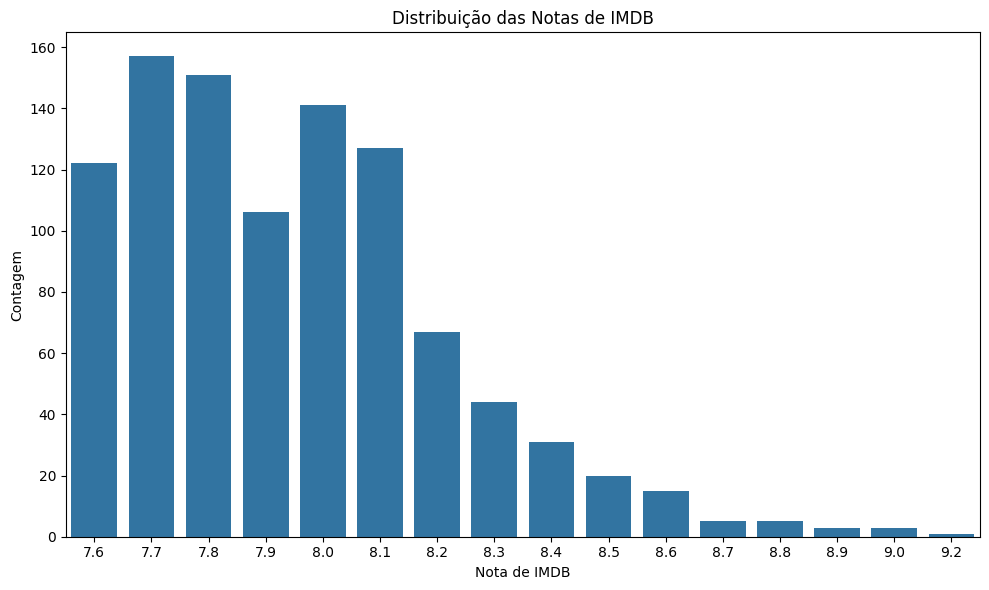

In [256]:
plt.figure(figsize=(10, 6))
sns.countplot(x='IMDB_Rating', data=df_movies)
plt.title('Distribuição das Notas de IMDB')
plt.xlabel('Nota de IMDB')
plt.ylabel('Contagem')
plt.tight_layout()
plt.show()

A análise do gráfico permite observar que:

A distribuição é assimétrica à esquerda, indicando uma forte concentração de filmes nas classificações menores.

As notas mais frequentes no dataset situam-se no intervalo entre 7.7 e 8.1.

---

Análise de Distribuição e Outliers com Boxplot

Para complementar a análise da distribuição da variável IMDB_Rating e investigar a presença de outliers, foi gerado um gráfico de boxplot.

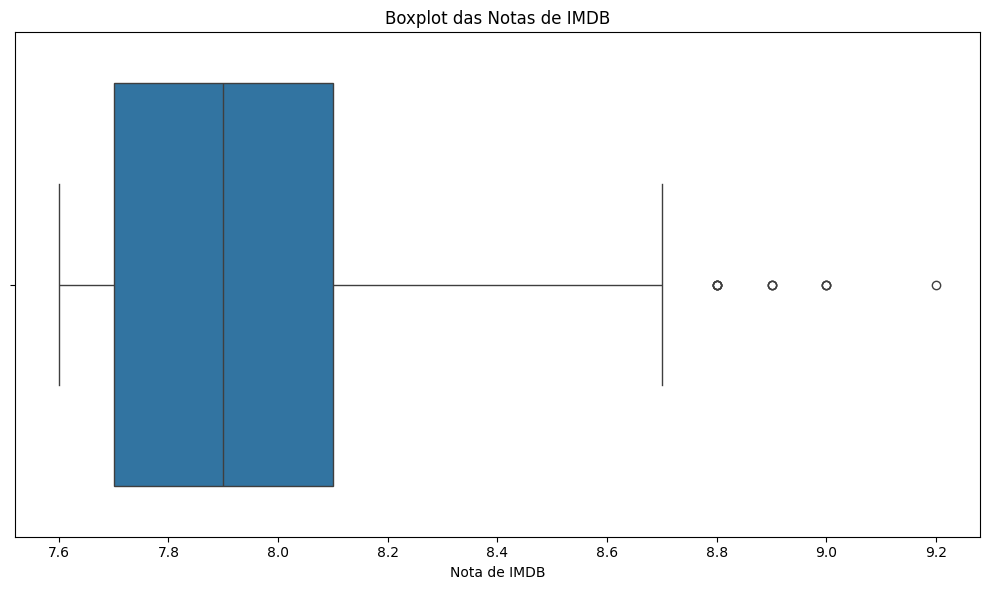

In [257]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='IMDB_Rating', data=df_movies)
plt.title('Boxplot das Notas de IMDB')
plt.xlabel('Nota de IMDB')
plt.tight_layout()
plt.show()

A visualização do boxplot permite destacar que:

Concentração dos Dados: Confirma-se que 50% dos filmes possuem notas concentradas entre aproximadamente 7.7 e 8.1, com a mediana em 7.9.

Identificação de Outliers: O gráfico identifica diversos pontos acima do seu limite superior, ou seja, filmes com notas altas em comparação com a maioria dos registros no dataset.

---

## Relação com a Variável Alvo:

Relação entre Meta Score e Nota IMDb

Para investigar a relação entre a avaliação da crítica (Meta Score) e a avaliação do público (IMDB Rating), foi gerado um gráfico de dispersão.

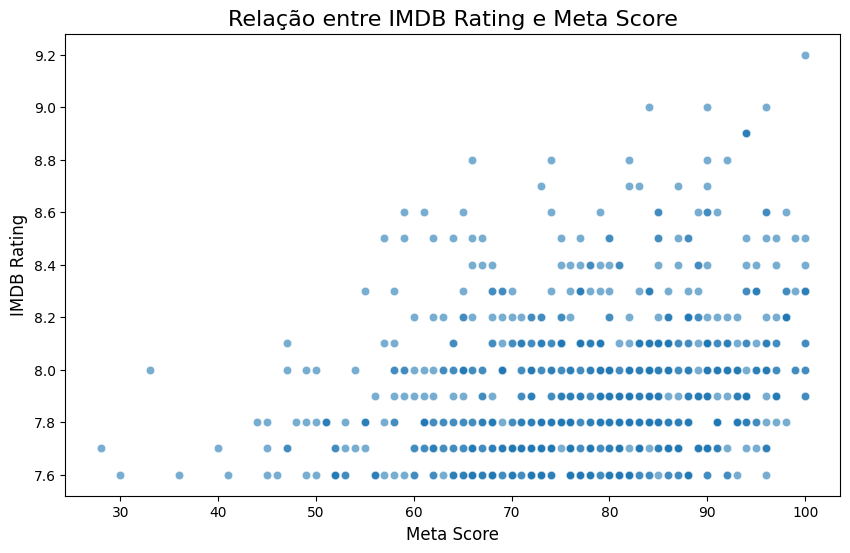

In [258]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='Meta_score', y='IMDB_Rating', alpha=0.6)
plt.title('Relação entre IMDB Rating e Meta Score', fontsize=16)
plt.xlabel('Meta Score', fontsize=12)
plt.ylabel('IMDB Rating', fontsize=12)
plt.show()

A análise do gráfico demonstra que:

Existe uma correlação positiva entre as duas variáveis. Observa-se que filmes com Meta Score mais alto também possuem um IMDB Rating mais elevado.

A dispersão dos pontos indica que a correlação, embora positiva, é moderada e não linear.
---

Para verificar a relação entre a nota do IMDB (IMDB Rating) e o número de votos (No_of_Votes), foi construído o seguinte gráfico de dispersão.

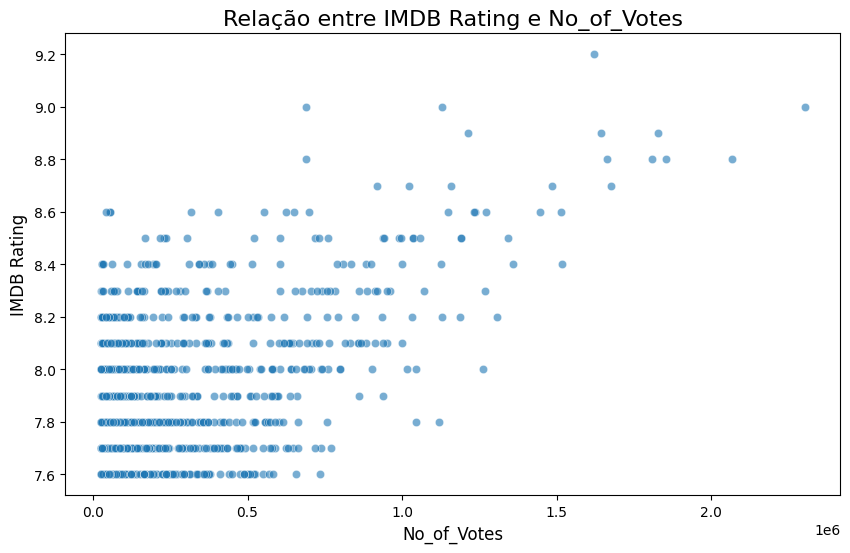

In [259]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='No_of_Votes', y='IMDB_Rating', alpha=0.6)
plt.title('Relação entre IMDB Rating e No_of_Votes', fontsize=16)
plt.xlabel('No_of_Votes', fontsize=12)
plt.ylabel('IMDB Rating', fontsize=12)
plt.show()

Analisando o gráfico, podemos concluir que:

Não existe uma relação direta entre as variáveis, filmes com poucos votos possuem grande variedade de notas.

Os filmes mais populares apresentam notas altas.

---

Foi criado um gráfico para verificar se o ano de lançamento de um filme (Released_Year) tem relação com a nota no IMDB (IMDB Rating).

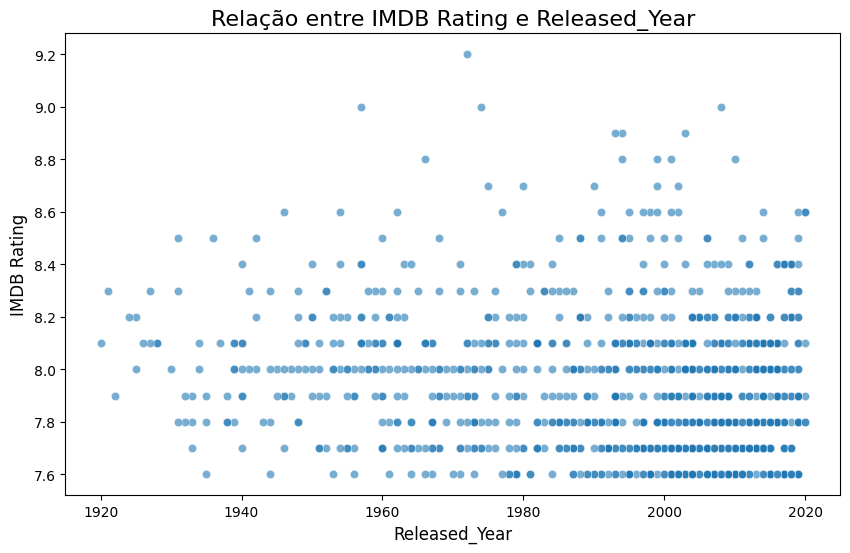

In [260]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='Released_Year', y='IMDB_Rating', alpha=0.6)
plt.title('Relação entre IMDB Rating e Released_Year', fontsize=16)
plt.xlabel('Released_Year', fontsize=12)
plt.ylabel('IMDB Rating', fontsize=12)
plt.show()

Analisando o gráfico, podemos concluir que:

Não há uma relação direta entre o ano de lançamento e a nota no IMDb, indicando que filmes bem avaliados estão distribuídos ao longo de todas as décadas.

As avaliações dos filmes se mantêm relativamente constantes com o tempo, sem tendência clara de aumento ou queda nas notas.

---

Foi criado um gráfico para verificar se o faturamento de um filme (Gross) tem alguma relação com a sua nota no IMDB (IMDB Rating).

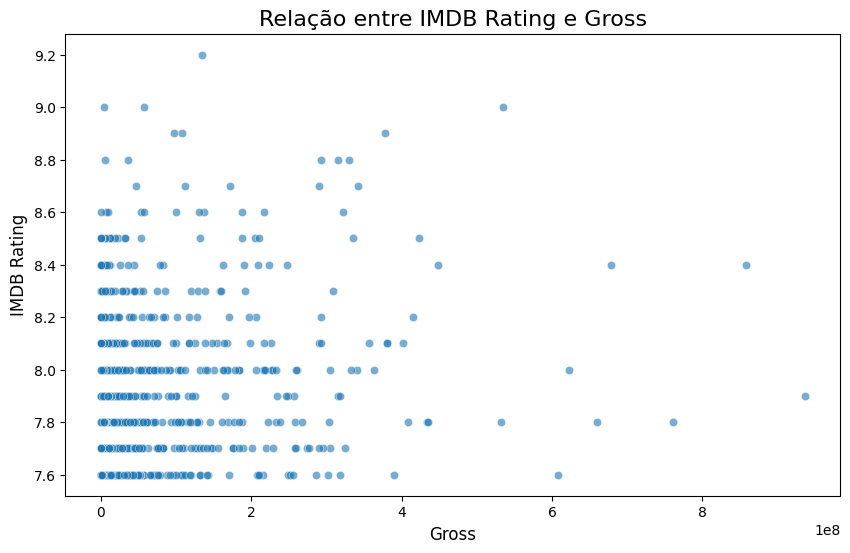

In [261]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='Gross', y='IMDB_Rating', alpha=0.6)
plt.title('Relação entre IMDB Rating e Gross', fontsize=16)
plt.xlabel('Gross', fontsize=12)
plt.ylabel('IMDB Rating', fontsize=12)
plt.show()

Não há uma correlação evidente entre a nota do IMDb e o faturamento dos filmes, sugerindo que altos ganhos não garantem avaliações mais altas.

A maioria dos filmes concentra-se em faixas de receita mais baixas (até 200 milhões).

Filmes com arrecadação extremamente alta também apresentam uma variedade de notas, indicando baixa relação.

Os filmes com maior receita tendem a ser menos numerosos e mais dispersos, com notas que variam amplamente entre 7.6 e 9.0.

---

Foi criado um gráfico para verificar se a duração de um filme (Runtime) tem alguma relação com a sua nota no IMDB (IMDB Rating).

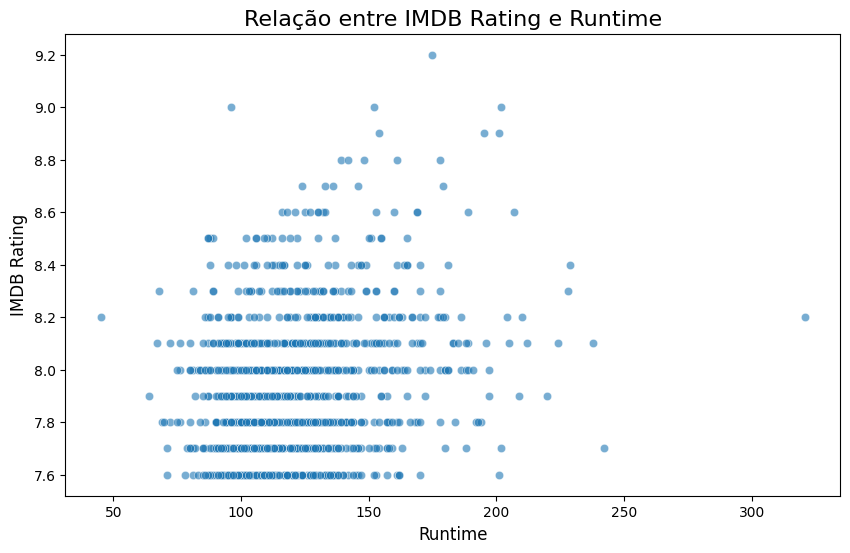

In [262]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='Runtime', y='IMDB_Rating', alpha=0.6)
plt.title('Relação entre IMDB Rating e Runtime', fontsize=16)
plt.xlabel('Runtime', fontsize=12)
plt.ylabel('IMDB Rating', fontsize=12)
plt.show()

Não existe uma relação clara entre a duração do filme (Runtime) e a nota no IMDb, indicando que filmes mais longos não necessariamente recebem avaliações melhores.

---

Para examinar a distribuição das notas do IMDb (IMDB Rating) entre os 10 certificados de idade mais comuns (Certificate), foi construído o seguinte gráfico de boxplot.

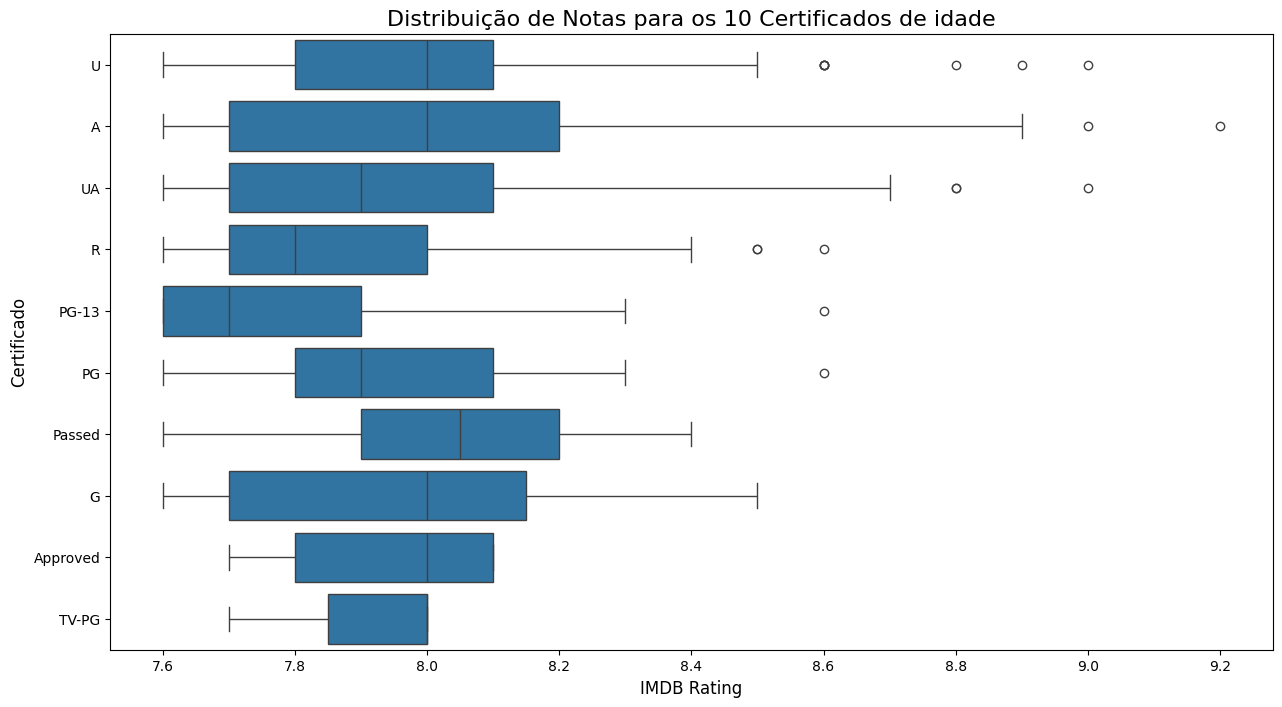

In [263]:
top_10_certifications = df_movies['Certificate'].value_counts().nlargest(10).index
df_certifications = df_movies[df_movies['Certificate'].isin(top_10_certifications)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_certifications, x='IMDB_Rating', y='Certificate', order=top_10_certifications)
plt.title('Distribuição de Notas para os 10 Certificados de idade', fontsize=16)
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Certificado', fontsize=12)
plt.show()

Analisando o gráfico, podemos concluir que:

As distribuições das notas do IMDB para os diferentes certificados de idade são relativamente próximas, com medianas em torno de 7.8 a 8.1.

Alguns certificados, como "A" e "UA", apresentam uma variação maior nas notas, indicando maior dispersão na avaliação dos filmes.

Certificados como "TV-PG" e "Approved" mostram uma distribuição mais compacta e notas medianas um pouco menores.

Existem alguns outliers em praticamente todas as categorias, indicando filmes com avaliações muito acima da média.

---

Para analisar a distribuição das notas do IMDB (IMDB Rating) entre os 10 gêneros de filmes mais frequentes (Genre), foi criado o gráfico de boxplot a seguir.

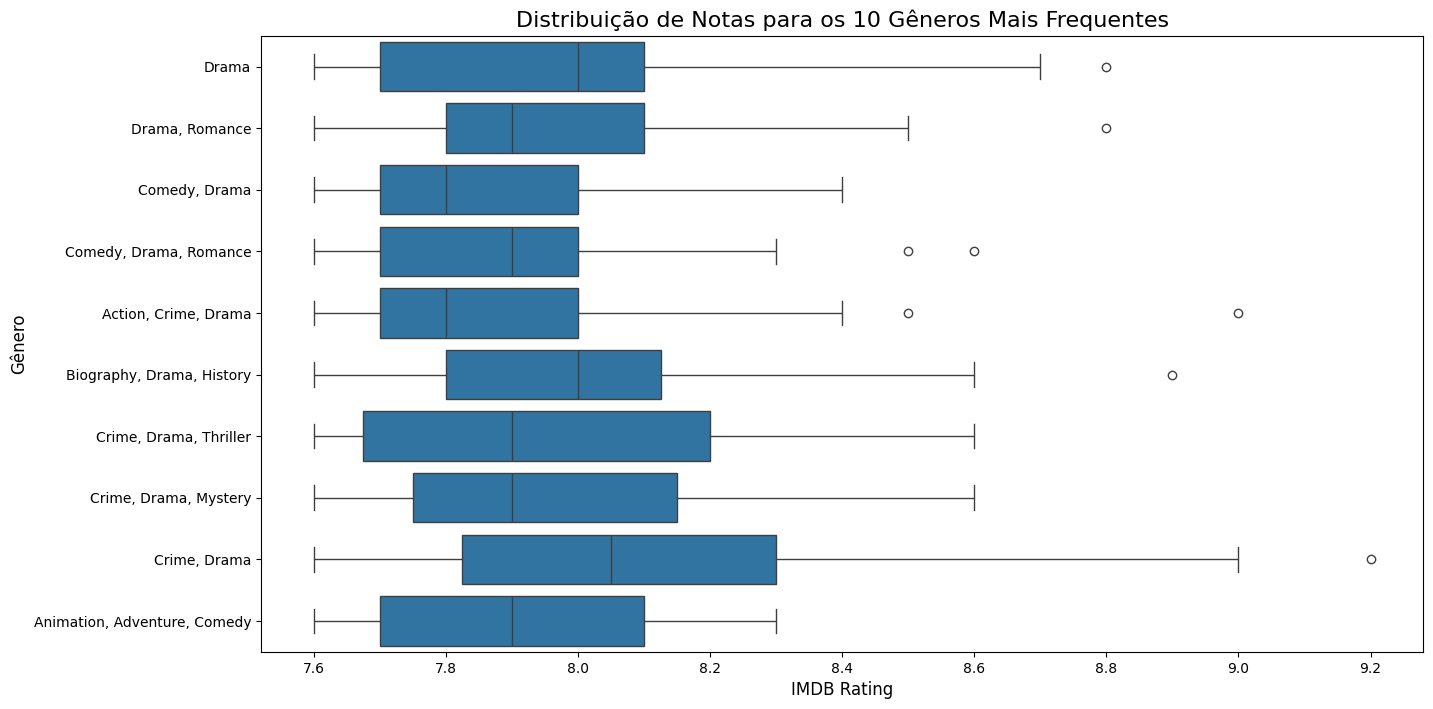

In [264]:
top_10_genres = df_movies['Genre'].value_counts().nlargest(10).index
df_genres = df_movies[df_movies['Genre'].isin(top_10_genres)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_genres, x='IMDB_Rating', y='Genre', order=top_10_genres)
plt.title('Distribuição de Notas para os 10 Gêneros Mais Frequentes', fontsize=16)
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Gênero', fontsize=12)
plt.show()

As distribuições das notas do IMDB para os diferentes gêneros são relativamente próximas, com medianas em torno de 7.8 a 8.1.

Alguns gêneros, como "Crime, Drama" e "Action, Crime, Drama", apresentam uma variação maior nas notas, indicando maior dispersão na avaliação dos filmes.

Gêneros como "Drama" e "Animation, Adventure, Comedy" mostram uma distribuição mais compacta e notas medianas um pouco menores.

Existem alguns outliers em praticamente todos os gêneros, indicando filmes com avaliações muito acima da média.

---

Para analisar a distribuição das notas do IMDB (IMDB Rating) entre os 10 diretores de filmes mais frequentes (Director), foi criado o gráfico de boxplot a seguir.

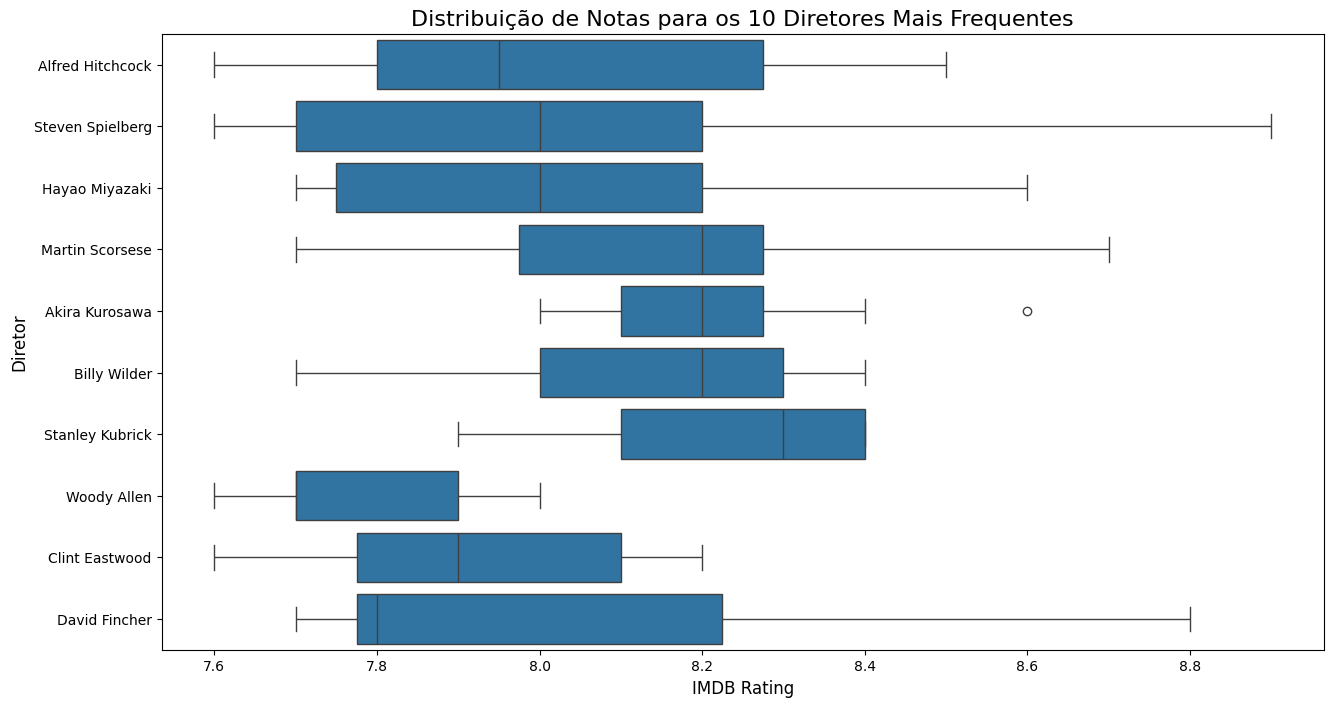

In [265]:
top_10_directors = df_movies['Director'].value_counts().nlargest(10).index
df_directors = df_movies[df_movies['Director'].isin(top_10_directors)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_directors, x='IMDB_Rating', y='Director', order=top_10_directors)
plt.title('Distribuição de Notas para os 10 Diretores Mais Frequentes', fontsize=16)
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Diretor', fontsize=12)
plt.show()

Analisando o gráfico, podemos concluir que:

As distribuições das notas do IMDb para os 10 diretores mais frequentes são relativamente próximas, com medianas variando entre 7.8 e 8.3.

Diretores como Stanley Kubrick e Martin Scorsese apresentam notas mais altas e distribuições mais concentradas, indicando avaliações consistentemente boas.

Já diretores como Steven Spielberg e David Fincher mostram uma variação maior nas notas, sugerindo maior diversidade na recepção de seus filmes.

---

Foi criado um boxplot com a distribuição das notas do IMDb para os 10 atores/atrizes mais frequentes em um DataFrame de filmes.

Foi utilizado o pd.melt para transformar o DataFrame original (df_movies), que continha as colunas separadas de atores/atrizes (Star1, Star2, Star3, Star4).

Por fim, para analisar a distribuição dos 10 atores mais frequentes (Star) em relação ao (IMDB), foi criado o gráfico de boxplot a seguir.

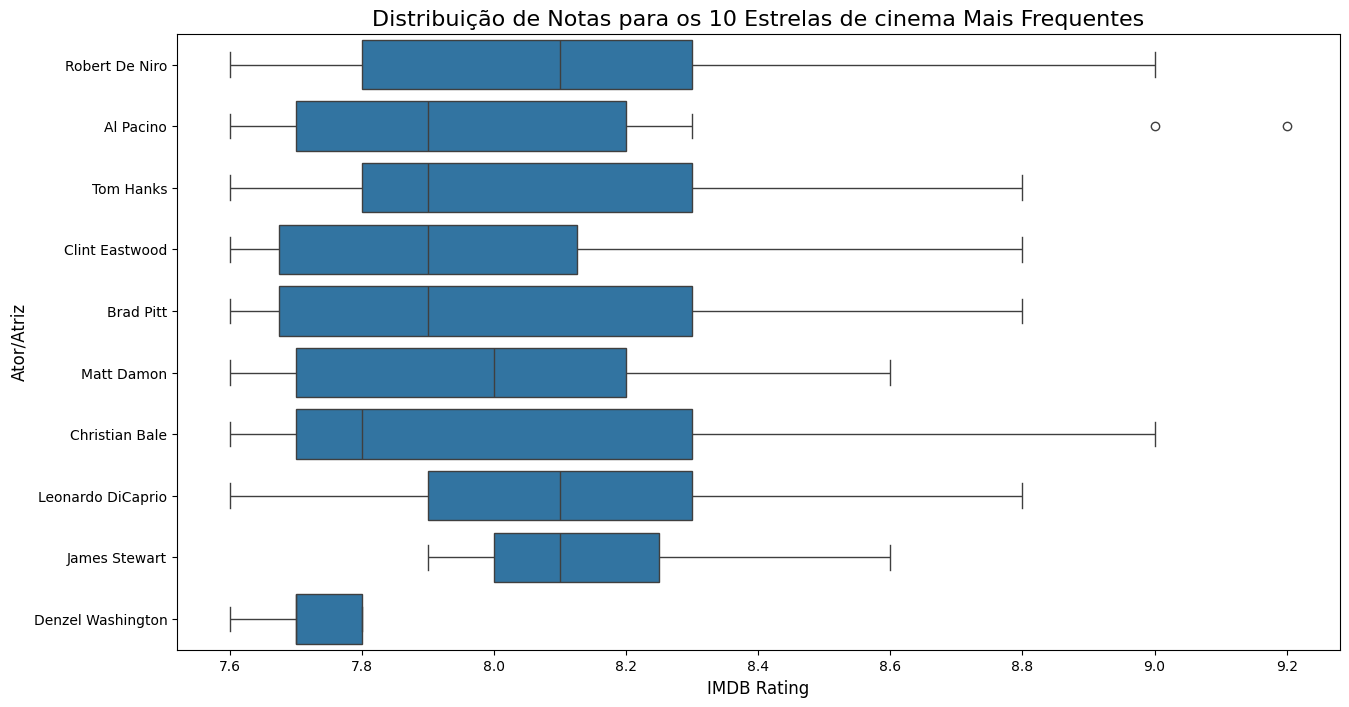

In [266]:
df_stars = pd.melt(df_movies,
                    id_vars=['IMDB_Rating'],
                    value_vars=['Star1', 'Star2', 'Star3', 'Star4'],
                    var_name='Star_Position',
                    value_name='Star')

top_10_stars = df_stars['Star'].value_counts().nlargest(10).index.tolist()

df_stars = df_stars[df_stars['Star'].isin(top_10_stars)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_stars, x='IMDB_Rating', y='Star', order=top_10_stars)
plt.title('Distribuição de Notas para os 10 Estrelas de cinema Mais Frequentes', fontsize=16)
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Ator/Atriz', fontsize=12)
plt.show()

Leonardo DiCaprio e Robert de Niro têm as notas mais altas e consistentes, com medianas acima de 8.0.

Robert De Niro, Al Pacino e Clint Eastwood apresentam grande variação nas notas, indicando participação tanto em filmes muito bons quanto em filmes com avaliações mais baixas.

Tom Hanks, Brad Pitt e Matt Damon têm boas medianas, em torno de 8.0, com variações moderadas.

James Stewart mostra uma distribuição estável e sem outliers.

Denzel Washington tem a distribuição mais concentrada, mas com mediana um pouco mais baixa (~7.8).

# Análises estatísticas

Foi realizado um teste de correlação entre a nota do IMDB e algumas variáveis numéricas, como tempo de duração (Runtime), arrecadação (Gross), ano de lançamento (Released_Year), número de votos (No_of_Votes) e nota do Metascore (Meta_score).

Para isso, foi utilizado o coeficiente de correlação de Spearman, que mede a relação monotônica entre as variáveis, ou seja, verifica se elas tendem a aumentar ou diminuir juntas, mesmo que essa relação não seja linear.

Esse método foi escolhido porque as variáveis analisadas não apresentam uma correlação linear clara com a nota do IMDb, sendo mais adequado identificar associações gerais e não necessariamente lineares.

O código realiza o cálculo do coeficiente de Spearman e o teste de significância para cada variável, informando se há evidência estatística de correlação positiva ou negativa entre elas e a nota do IMDb.

Correlação Linear

Ho = não há corrrelação linear: p > 0,05

Ha = existe correlação linear: p <= 0,05

In [267]:
import scipy.stats as stats

df_columns = ['Runtime', 'Gross', 'Released_Year', 'No_of_Votes', 'Meta_score']

print('Teste de Correlação utilizando Spearman')
print("*" * 50)

for col in df_columns:
    temp_df = df_movies[['IMDB_Rating', col]].dropna()

    coef, p = stats.spearmanr(temp_df['IMDB_Rating'], temp_df[col])

    print(f"Analisando a correlação para: '{col}'")
    if p > 0.05:
        print(f'-> Não há evidência de correlação.')
    else:
        if coef > 0:
            print(f'-> Há uma correlação POSITIVA.')
        else:
            print(f'-> Há uma correlação NEGATIVA.')

    print('   Coeficiente de Spearman: {:.3f}'.format(coef))
    print('   p-valor: {:.4f}'.format(p))
    print("-" * 30)


Teste de Correlação utilizando Spearman
**************************************************
Analisando a correlação para: 'Runtime'
-> Há uma correlação POSITIVA.
   Coeficiente de Spearman: 0.212
   p-valor: 0.0000
------------------------------
Analisando a correlação para: 'Gross'
-> Não há evidência de correlação.
   Coeficiente de Spearman: -0.048
   p-valor: 0.1691
------------------------------
Analisando a correlação para: 'Released_Year'
-> Há uma correlação NEGATIVA.
   Coeficiente de Spearman: -0.127
   p-valor: 0.0001
------------------------------
Analisando a correlação para: 'No_of_Votes'
-> Há uma correlação POSITIVA.
   Coeficiente de Spearman: 0.213
   p-valor: 0.0000
------------------------------
Analisando a correlação para: 'Meta_score'
-> Há uma correlação POSITIVA.
   Coeficiente de Spearman: 0.285
   p-valor: 0.0000
------------------------------


Runtime, No_of_Votes e Meta_score mostraram correlação positiva significativa, indicando que filmes mais longos, mais votados e com melhor avaliação da crítica tendem a ter notas maiores.

Released_Year apresentou correlação negativa significativa, sugerindo que filmes mais recentes têm notas ligeiramente menores.

Gross não apresentou correlação significativa com a nota do IMDb.

As correlações são fracas a moderadas, mas indicam algumas relações imp

Foi gerado um heatmap para visualizar as correlações entre variáveis numéricas do DataFrame, incluindo o IMDB_Rating.

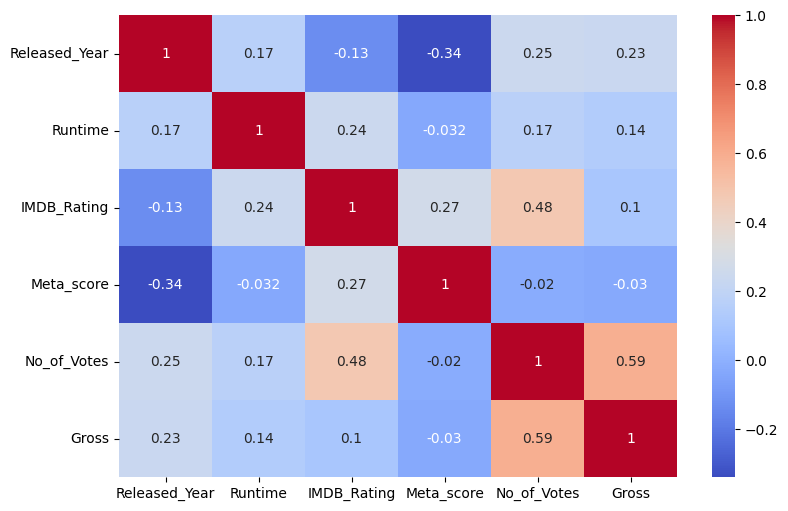

In [268]:
corr = df_movies.corr(numeric_only=True)
plt.figure(figsize=(9, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

A correlação entre IMDB_Rating e No_of_Votes é positiva moderada (0.48), indicando que filmes com mais votos tendem a ter notas maiores.

A relação entre IMDB_Rating e Meta_score é positiva, porém mais fraca (0.27), mostrando que a avaliação crítica está associada às notas do público.

A correlação entre IMDB_Rating e Runtime é pequena, mas positiva (0.24), sugerindo que filmes mais longos podem ter avaliações ligeiramente maiores.

A variável Released_Year apresenta correlação negativa com IMDB_Rating (-0.13), indicando que filmes mais recentes têm notas um pouco menores.

As variáveis No_of_Votes e Gross têm alta correlação entre si (0.59), indicando que filmes que arrecadam mais tendem a receber mais votos.

# Engenharia de Features

Para reduzir a dimensionalidade e evitar categorias com pouca representatividade, foram selecionados os 10 diretores mais frequentes e os 10 atores principais de cada posição (Star1 a Star4).

Se o diretor ou ator estiver entre os 10 mais recorrentes, o valor é mantido;

Caso contrário, é substituído pela categoria "Outro".

In [269]:
top_10_directors = df_movies['Director'].value_counts().nlargest(10).index
df_movies['Directors'] = df_movies['Director'].apply(lambda x: x if x in top_10_directors else 'Outro')

In [270]:
top_10_star1 = df_movies['Star1'].value_counts().nlargest(10).index
df_movies['Star1_Top10'] = df_movies['Star1'].apply(lambda x: x if x in top_10_star1 else 'Outro')

top_10_star2 = df_movies['Star2'].value_counts().nlargest(10).index
df_movies['Star2_Top10'] = df_movies['Star2'].apply(lambda x: x if x in top_10_star2 else 'Outro')

top_10_star3 = df_movies['Star3'].value_counts().nlargest(10).index
df_movies['Star3_Top10'] = df_movies['Star3'].apply(lambda x: x if x in top_10_star3 else 'Outro')

top_10_star4 = df_movies['Star4'].value_counts().nlargest(10).index
df_movies['Star4_Top10'] = df_movies['Star4'].apply(lambda x: x if x in top_10_star4 else 'Outro')

# Perguntas

# Pergunta a)  Qual filme você recomendaria para uma pessoa que você não conhece?


Para responder à pergunta foi criado um filtro no df_movies.

Foram escolhidos filmes com nota do IMDb maior ou igual a 8.0 e que possuem diretor e ator principal (Star) entre os 10 mais frequentes.

Em seguida, os filmes que atendem a esses critérios foram ordenados pela nota do IMDb em ordem decrescente, e os 3 melhores resultados foram selecionados como recomendações.

In [271]:
recomendation = df_movies[
    (df_movies['IMDB_Rating'] >= 8.0) &
    (df_movies['Directors'].isin(top_10_directors)) &
    (df_movies['Star1_Top10'].isin(top_10_star1))
]

top_filmes = recomendation.sort_values(by=['IMDB_Rating'], ascending=False).head(3)['Series_Title'].tolist()
print("Filmes recomendados:")
print(top_filmes)

Filmes recomendados:
['Goodfellas', 'Saving Private Ryan', 'The Departed']


---

# Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?


Para responder a essa pergunta, foi calculada a correlação entre as variáveis numéricas do DataFrame df_movies e a variável Gross (faturamento bruto).

A função corr() foi utilizada com o parâmetro numeric_only=True para considerar apenas variáveis numéricas. Em seguida, os resultados foram ordenados em ordem decrescente para identificar quais variáveis apresentam maior correlação com o faturamento.

Além disso, foi gerado um mapa de calor (heatmap) para visualizar melhor as correlações entre essas variáveis, com destaque para aquelas mais relacionadas ao Gross.

Gross            1.000000
No_of_Votes      0.590015
Released_Year    0.233270
Runtime          0.139434
IMDB_Rating      0.100980
Meta_score      -0.030452
Name: Gross, dtype: float64


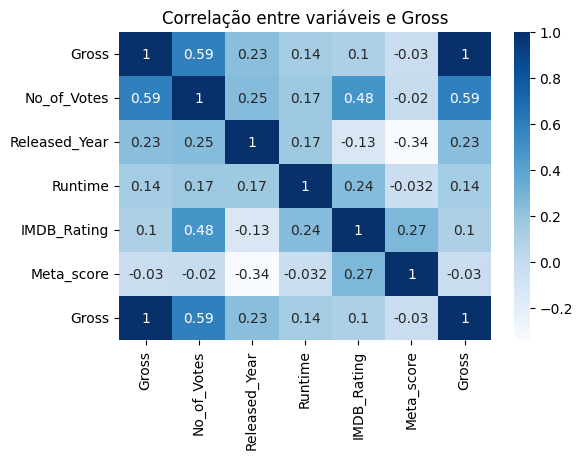

In [272]:
corr = df_movies.corr(numeric_only=True)['Gross'].sort_values(ascending=False)
print(corr)


plt.figure(figsize=(6,4))
sns.heatmap(df_movies[corr.index.to_list() + ['Gross']].corr(), annot=True, cmap="Blues")
plt.title("Correlação entre variáveis e Gross")
plt.show()

A variável com maior correlação com o faturamento foi o número de votos (No_of_Votes), com um coeficiente de 0.59, indicando uma relação positiva moderada. Isso sugere que filmes que alcançam maior público (e recebem mais votos) tendem a ter um faturamento mais alto.

O ano de lançamento (Released_Year) também apresentou correlação positiva (0.23), indicando que filmes mais recentes tendem a faturar mais — possivelmente devido ao aumento do público ou à inflação nos valores de bilheteria.

Outras variáveis como duração (Runtime) e nota do IMDb (IMDB_Rating) mostraram correlações positivas mais fracas, com valores de 0.14 e 0.10, respectivamente.

---

# Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Para explorar essa questão, foi utilizada a técnica de extração de características de texto com o CountVectorizer, da biblioteca sklearn. Esse método transforma a coluna Overview — que contém resumos dos filmes — em uma matriz de contagem de palavras.

Foi configurado o CountVectorizer para:

Remover palavras irrelevantes em inglês

Considerar apenas as 10 palavras mais frequentes

In [273]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words='english', max_features=10)
X = vec.fit_transform(df_movies['Overview'])
words_overview = vec.get_feature_names_out()

for word in words_overview:
  print(word)

family
life
love
man
new
story
war
woman
world
young


As palavras revelam temas recorrentes nos filmes, como: family, love, man, woman, young , story, new, life, war, world

Esses termos sugerem que muitos filmes giram em torno de dramas familiares, romances, histórias de crescimento pessoal ou conflitos globais, o que é comum em gêneros como drama, romance, ação ou guerra.


Embora essas palavras não indiquem diretamente o gênero, elas podem ser bons indicadores. Por exemplo:

Palavras como war e world podem apontar para ação, história ou guerra

Palavras como love, family, woman e young podem indicar drama ou romance

---

Para possibilitar análises mais detalhadas com a coluna Genre, foi realizado um pré-processamento para transformar as informações de gênero em um formato adequado para análise.

Primeiramente, os valores da coluna Genre, foram separados por vírgula (ex: "Action, Adventure, Sci-Fi"), foram convertidos para listas utilizando o método str.split(', ').

Em seguida, foi utilizado o MultiLabelBinarizer da biblioteca sklearn para transformar essas listas em um formato binário, no qual cada gênero passou a ser representado por uma coluna distinta. O valor 1 indica que o filme pertence aquele gênero, e 0 indica que não pertence.

Essas novas colunas foram armazenadas em um novo DataFrame e posteriormente concatenadas ao DataFrame original (df_movies). Com isso, cada filme passou a ter colunas separadas para cada gênero.

In [274]:
df_movies['Genre'] = df_movies['Genre'].str.split(', ')

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_movies['Genre'])

df_genre = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_movies.index)

df_movies = pd.concat([df_movies, df_genre], axis=1)

As colunas que não foram utilizadas no modelo de previsão foram removidas.

In [275]:
df_movies.drop(columns=['Series_Title', 'Genre', 'Director','Star1','Star2','Star3','Star4'], inplace=True)

Para identificar os valores ausente dos dados, foi calculado o percentual de valores nulos em cada coluna do DataFrame df_movies.


**Obs:** O tratamento dos valores nulos foi feito dentro do pipeline de pré-processamento

# Preparação para Modelagem Preditiva

Para preparar os dados para a etapa de modelagem preditiva, foi feita a separação entre:

X: as variáveis independentes (todas as colunas, exceto a variável alvo IMDB_Rating)

y: a variável dependente, ou seja, o que se deseja prever (IMDB_Rating)

In [276]:
X = df_movies.drop('IMDB_Rating', axis=1)
y = df_movies['IMDB_Rating']

Os dados foram divididos entre conjunto de treino e conjunto de teste, utilizando a função train_test_split, 35% dos dados foram reservados para teste, enquanto 65% ficaram para o treinamento:

In [277]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.35, random_state=7)

Para prever a nota IMDB de um filme, foi construído um pipeline de machine learning que realiza todas as etapas de pré-processamento e modelagem de forma automatizada e organizada. O objetivo era utilizar os dados disponíveis para estimar o valor da variável IMDB_Rating, que representa a nota do filme segundo os usuários.

Como a variável alvo (IMDB_Rating) é numérica e contínua, estamos tratando de um problema de regressão.

No pipeline, foram utilizadas todas as variáveis disponíveis no conjunto de dados (com exceção da própria nota IMDB), sendo cada tipo de variável tratado de maneira adequada:

Variáveis numéricas foram preenchidas com a média em caso de valores ausentes e padronizadas utilizando StandardScaler, garantindo que todas fiquem na mesma escala.

Variáveis categóricas tiveram os valores nulos preenchidos com a categoria mais frequente e foram transformadas com OneHotEncoder.

A variável Overview, foi processada utilizando o TfidfVectorizer, que extrai os termos mais relevantes dos textos, removendo palavras comuns e irrelevantes.

Após o treinamento do modelo, foram utilizadas três métricas principais para avaliar o desempenho:

R² Score, que indica a proporção da variância explicada pelo modelo. Quanto mais próximo de 1, melhor o modelo está ajustado aos dados.

RMSE (Root Mean Squared Error), que mede o erro médio das previsões, penalizando mais os erros maiores.

MAE (Mean Absolute Error), que mede o erro absoluto médio entre as previsões e os valores reais.

In [278]:
def train_pipeline(modelo, X_treino, X_teste, y_treino, y_teste):

    features_numericas = X_treino.select_dtypes(include=np.number).columns.tolist()
    features_categoricas = X_treino.select_dtypes(include=['object', 'category']).columns.tolist()

    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    onehot_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessador = ColumnTransformer(
        transformers=[
            ('num', num_transformer, features_numericas),
            ('text', TfidfVectorizer(max_features=1000, stop_words='english'), 'Overview'),
            ('onehot', onehot_transformer, features_categoricas),

        ],
        remainder='passthrough'
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessador),
        ('model', modelo)
    ])

    pipeline.fit(X_treino, y_treino)

    print("\n--- Métricas de Avaliação ---")

    score_treino = pipeline.score(X_treino, y_treino)
    print(f"R² Score (Treino): {score_treino:.4f}")

    score_teste = pipeline.score(X_teste, y_teste)
    print(f"R² Score (Teste): {score_teste:.4f}")

    y_pred = pipeline.predict(X_teste)
    rmse = np.sqrt(mean_squared_error(y_teste, y_pred))
    mae = mean_absolute_error(y_teste, y_pred)
    print(f"RMSE (Teste): {rmse:.4f}")
    print(f"MAE (Teste): {mae:.4f}")

    return pipeline

# Treinamento

Treinamento com Regressão Linear


Para prever a nota IMDb dos filmes, foi utilizado inicialmente o modelo de Regressão Linear:

In [279]:
linear_model = LinearRegression()
final_linear = train_pipeline(linear_model, x_treino, x_teste, y_treino, y_teste)


--- Métricas de Avaliação ---
R² Score (Treino): 1.0000
R² Score (Teste): 0.1659
RMSE (Teste): 0.2332
MAE (Teste): 0.1862


O modelo de Regressão Linear apresentou R² de 1.00 no treino e apenas 0.1659 no teste, indicando overfitting — ou seja, o modelo se ajustou demais aos dados de treino e não generalizou bem.

Os erros médios no teste foram:

RMSE: 0.2332

MAE: 0.1862

Apesar dos erros não serem altos, o baixo R² no teste mostra que o modelo não explica bem a variabilidade da nota IMDb em novos dados.

---

Treinamento com XGBoost

Foi utilizado o modelo de XGBoost Regressor.

Principais hiperparâmetros escolhidos:

n_estimators=150: número de árvores para o modelo aprender mais padrões.

max_depth=2: limite a profundidade das árvores para evitar overfitting.

learning_rate=0.05: passo menor na aprendizagem, deixando o treinamento mais estável.

subsample=0.7 e colsample_bytree=0.7: usam apenas parte dos dados e variáveis por árvore para melhorar a generalização.

reg_alpha=1 e reg_lambda=5: penalizações que ajudam a evitar modelos muito complexos.

In [280]:
xgboost =  XGBRegressor(
    n_estimators=150,
    max_depth=2,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=5,
    random_state=7
)
final_xg = train_pipeline(xgboost,x_treino, x_teste, y_treino, y_teste)


--- Métricas de Avaliação ---
R² Score (Treino): 0.6310
R² Score (Teste): 0.4829
RMSE (Teste): 0.1836
MAE (Teste): 0.1445


O modelo XGBoost apresentou um R² de 0.63 no treino e 0.49 no teste, mostrando que ele aprendeu bem os dados e generalizou melhor que a regressão linear.

Os erros ficaram menores, com RMSE de 0.18 e MAE de 0.14, indicando previsões mais precisas.

---

Foi utilizado um modelo de Random Forest Regressor:

In [281]:
random = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    random_state=7
)

final_random = train_pipeline(random,x_treino, x_teste, y_treino, y_teste)


--- Métricas de Avaliação ---
R² Score (Treino): 0.5561
R² Score (Teste): 0.4105
RMSE (Teste): 0.1960
MAE (Teste): 0.1585


Resultados obtidos

R² (treino): 0.5561

R² (teste): 0.4105

RMSE (teste): 0.1970

MAE (teste): 0.1581

O modelo apresentou um desempenho razoável, com R² de 0.55 no treino e 0.41 no teste, mostrando capacidade de generalização melhor que a Regressão Linear, mas ainda inferior ao XGBoost.


---

Foi utilizado o modelo CatBoost Regressor

Principais hiperparâmetros:

iterations = 150: número de árvores utilizadas no treinamento.

learning_rate = 0.03: taxa de aprendizado baixa, para garantir estabilidade.

depth = 3: profundidade das árvores, utilizada para evitar overfitting.

In [282]:
catboost = CatBoostRegressor (iterations=150, learning_rate=0.03, depth = 3, random_state = 7, verbose=False)
final_catboost = train_pipeline(catboost, x_treino, x_teste, y_treino, y_teste)


--- Métricas de Avaliação ---
R² Score (Treino): 0.4994
R² Score (Teste): 0.3970
RMSE (Teste): 0.1983
MAE (Teste): 0.1617


O modelo CatBoost teve um desempenho razoável, com R² de 0.50 no treino e 0.40 no teste, mostrando um ajuste moderado.

Os erros (RMSE e MAE) foram próximos aos obtidos pelo Random Forest, porém ainda acima do XGBoost.

---

# Qual modelo melhor se aproxima dos dados? Prós e Contras

O XGBoost foi o modelo que apresentou o melhor desempenho geral, alcançando o maior R² no teste (0.49) e os menores erros (RMSE e MAE). Isso mostra que ele conseguiu capturar de forma mais eficiente as relações entre as variáveis e a nota IMDb.

**Pontos fortes do XGBoost**

*   Excelente desempenho em dados complexos.
*   Possui mecanismos de regularização, que ajudam a reduzir o overfitting.
*   Grande flexibilidade de ajustes por meio de diversos hiperparâmetros.

**Limitações do XGBoost**

*   Maior tempo de treinamento, especialmente em bases maiores.
*   Requer mais esforço para ajustar hiperparâmetros de forma adequada.

---

# Previsão novo filme

Por fim, foi realizado o teste de regressão utilizando como exemplo o filme The Shawshank Redemption.

Para isso, foram aplicadas as mesmas etapas de pré-processamento dos dados usadas no treinamento do modelo, garantindo consistência entre treino e predição.

As transformações incluíram:

Conversão de variáveis numéricas armazenadas como texto (Gross, Released_Year, Runtime);

Codificação dos gêneros com o MultiLabelBinarizer previamente ajustado;

Tratamento de colunas categóricas de Diretor e Atores principais, restringindo-os aos Top 10 mais relevantes e agrupando os demais em "Outro";

Remoção de colunas descritivas ou não utilizadas no modelo (Series_Title, Genre, Director, Star1–Star4).

Após o pré-processamento, o filme foi passado ao modelo XGBoost Regressor, previamente treinado e ajustado com os melhores hiperparâmetros, para a obtenção da previsão da nota no IMDb.

In [283]:
new_movie_dict = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


In [284]:
df_new_movie = pd.DataFrame([new_movie_dict])

In [285]:
df_new_movie["Gross"] = df_new_movie["Gross"].str.replace(",", "").astype(float)
df_new_movie = df_new_movie[df_new_movie["Released_Year"].str.isnumeric()]
df_new_movie["Released_Year"] = df_new_movie["Released_Year"].astype(int)
df_new_movie.Runtime = df_new_movie.Runtime.str.replace(' min', '').astype(int)

genre_encoded_new = mlb.transform(df_new_movie['Genre'])
df_genre_new = pd.DataFrame(genre_encoded_new, columns=mlb.classes_, index=df_new_movie.index)
df_new_movie = pd.concat([df_new_movie, df_genre_new], axis=1)

df_new_movie['Directors'] = df_new_movie['Director'].apply(
    lambda x: x if x in top_10_directors else 'Outro'
)

for i, top_list in enumerate([top_10_star1, top_10_star2, top_10_star3, top_10_star4], start=1):
    df_new_movie[f"Star{i}_Top10"] = df_new_movie[f"Star{i}"].apply(
        lambda x: x if x in top_list else "Outro"
    )

In [286]:
df_new_movie.drop(columns=['Series_Title', 'Genre', 'Director','Star1','Star2','Star3','Star4'], inplace=True)

In [287]:
prevision = final_xg.predict(df_new_movie)

Após a preparação do novo filme com as mesmas etapas de pré-processamento aplicadas no conjunto de treino, o dado foi passado ao modelo final XGBoost Regressor.

In [288]:
nota_prevista = prevision[0]

print("Filme : The Shawshank Redemption")
print(f"Nota prevista para o IMDb: {nota_prevista:.2f}")

Filme : The Shawshank Redemption
Nota prevista para o IMDb: 8.59


# Salvando o Modelo Treinado

Após o ajuste do XGBoost Regressor com os melhores hiperparâmetros e validação de performance, o modelo final foi salvo utilizando a biblioteca pickle.

In [289]:
with open('pipeline_treinado.pkl', 'wb') as f:
    pickle.dump(final_xg, f)